In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

In [2]:
db = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Rat@#1234',
    database='ecommerce'
)
cur = db.cursor()

# 1. List all unique cities where customers are located.

In [3]:
query = """SELECT DISTINCT customer_city FROM customers"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# 2. Count the number of orders placed in 2017.

In [4]:
query = """SELECT COUNT(order_id) FROM orders WHERE YEAR(order_purchase_timestamp) = 2017"""
cur.execute(query)
data = cur.fetchall()
'total order placed in 2017 are :',data[0][0]

('total order placed in 2017 are :', 45101)

# 3. Find the total sales per category.

In [5]:
query = """SELECT products.product_category AS category, ROUND(SUM(payments.payment_value),2) FROM products
JOIN order_items
ON products.product_id = order_items.product_id
JOIN payments
ON payments.order_id = order_items.order_id
GROUP BY category"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ['Category', 'Payment'])
df

,Category,Payment
0,perfumery,506738.66
1,Furniture Decoration,1430176.39
2,telephony,486882.05
3,Fashion Bags and Accessories,218158.28
4,bed table bath,1712553.67
...,...,...
69,cds music dvds,1199.43
70,La Cuisine,2913.53
71,Fashion Children's Clothing,785.67
72,PC Gamer,2174.43


# 4. Calculate the percentage of orders that were paid in installments.

In [6]:
query = """SELECT (SUM(CASE WHEN payment_installments >= 1 THEN 1
ELSE 0 END))/COUNT(*)*100 FROM payments"""
cur.execute(query)
data = cur.fetchall()
data

[(Decimal('99.9981'),)]

# 5. Count the number of customers from each state.

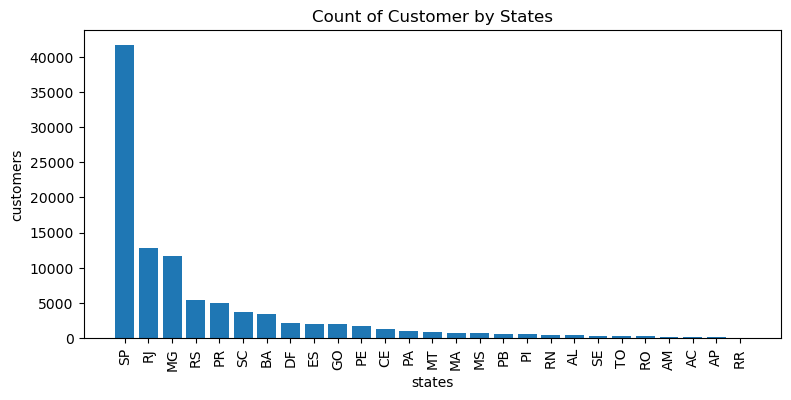

In [7]:
query = """SELECT customer_state, COUNT(customer_id) FROM customers
GROUP BY customer_state"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["states","customers"])
df = df.sort_values(by = "customers", ascending = False)

plt.figure(figsize = (9,4))
plt.bar(df["states"],df["customers"])
plt.xlabel("states")
plt.ylabel("customers")
plt.title("Count of Customer by States")
plt.xticks(rotation = 90)
plt.show()

# 6. Calculate the number of orders per month in 2018.

[Text(0, 0, '7269'),
 Text(0, 0, '6728'),
 Text(0, 0, '7211'),
 Text(0, 0, '6939'),
 Text(0, 0, '6873'),
 Text(0, 0, '6167'),
 Text(0, 0, '6292'),
 Text(0, 0, '6512'),
 Text(0, 0, '16'),
 Text(0, 0, '4')]

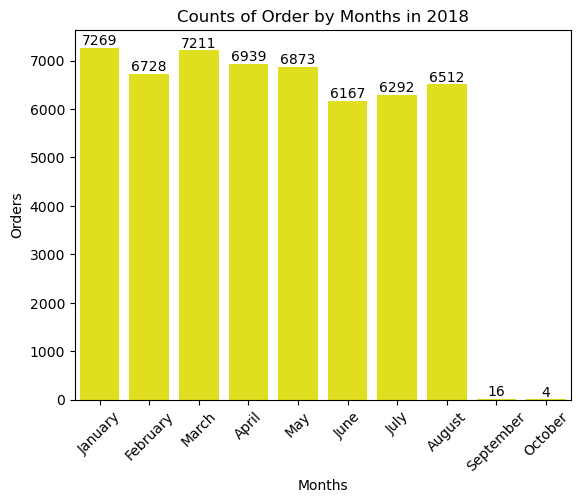

In [8]:
query = """SELECT monthname(order_purchase_timestamp) months, COUNT(order_id) order_count
FROM orders WHERE year(order_purchase_timestamp) = 2018
GROUP BY months"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Months","Orders"])
o = ["January","February","March","April","May","June","July","August","September","October"]
ax = sns.barplot(x = df["Months"],y = df["Orders"], data = df, order = o, color = "yellow")
plt.xticks(rotation = 45)
plt.title("Counts of Order by Months in 2018")
ax.bar_label(ax.containers[0])

# 7. Find the average number of products per order, grouped by customer city.

In [9]:
query = """WITH count_per_order AS (SELECT orders.order_id, orders.customer_id, COUNT(order_items.order_id) AS oc FROM orders
JOIN order_items ON orders.order_id = order_items.order_id
GROUP BY orders.order_id, orders.customer_id)
SELECT customers.customer_city,ROUND(AVG(count_per_order.oc),2) average_orders
FROM customers JOIN count_per_order
ON customers.customer_id = count_per_order.customer_id
GROUP BY customers.customer_city ORDER BY average_orders DESC"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["City","Avg_order"])
df.head(10)

,City,Avg_order
0,padre carvalho,7.00
1,celso ramos,6.50
2,candido godoi,6.00
3,datas,6.00
4,matias olimpio,5.00
5,morro de sao paulo,4.00
6,cidelandia,4.00
7,picarra,4.00
8,teixeira soares,4.00
9,curralinho,4.00


# 8. Calculate the percentage of total revenue contributed by each product category.

In [10]:
query = """SELECT products.product_category AS category, ROUND((SUM(payments.payment_value)/(SELECT SUM(payment_value) FROM payments))*100,2) sales_perc FROM products
JOIN order_items
ON products.product_id = order_items.product_id
JOIN payments
ON payments.order_id = order_items.order_id
GROUP BY category
ORDER BY sales_perc DESC;"""
cur.execute(query)
data = cur.fetchall()
data
df = pd.DataFrame(data, columns = ["Category","Perc_distribution"])
df.head(10)

,Category,Perc_distribution
0,bed table bath,10.70
1,HEALTH BEAUTY,10.35
2,computer accessories,9.90
3,Furniture Decoration,8.93
4,Watches present,8.93
5,sport leisure,8.70
6,housewares,6.84
7,automotive,5.32
8,Garden tools,5.24
9,Cool Stuff,4.87


# 9. Identify the correlation between product price and the number of times a product has been purchased.

In [11]:
import numpy as np
query = """SELECT products.product_category, COUNT(order_items.product_id),ROUND(AVG(order_items.price))
FROM products
JOIN order_items
ON products.product_id = order_items.product_id
GROUP BY products.product_category;"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["prod_category","order_count","price"])
arr1 = df["order_count"]
arr2 = df["price"]
a = np.corrcoef([arr1, arr2])
print("the correlation between price and number of times a product has been purchased is: ", a[0][1])

the correlation between price and number of times a product has been purchased is:  -0.10643950249375146


# 10. Calculate the total revenue generated by each seller, and rank them by revenue.

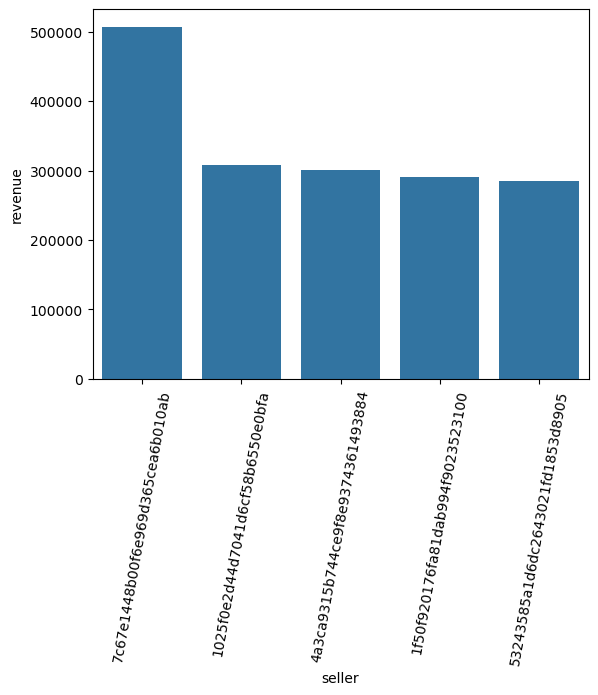

In [15]:
query = """SELECT *, RANK() OVER(ORDER BY revenue DESC) AS rn FROM 
(SELECT order_items.seller_id, SUM(payments.payment_value) revenue
FROM order_items join payments
USING(order_id)
GROUP BY order_items.seller_id) AS a;"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["seller","revenue","rank"])
df = df.head()
sns.barplot(x = "seller", y = "revenue", data = df)
plt.xticks(rotation = 80)
plt.show()

# 11. Calculate the moving average of order values for each customer over their order history.

In [21]:
query = """SELECT customer_id, order_purchase_timestamp, payment,
AVG(payment) OVER(PARTITION BY customer_id ORDER BY order_purchase_timestamp
ROWS BETWEEN 2 PRECEDING AND CURRENT ROW) AS mov_avg
FROM
(SELECT orders.customer_id, orders.order_purchase_timestamp,
payments.payment_value AS payment
FROM payments JOIN orders
ON payments.order_id = orders.order_id) AS a;"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["customer","purchase_time","payment","avg_moving_price"])
df

,customer,purchase_time,payment,avg_moving_price
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002
...,...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,71.23,27.120001
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13,63.130001
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.130005
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000


# 12. Calculate the cumulative sales per month for each year.

In [34]:
query = """SELECT years, months, payment, SUM(payment)
over(order by years, months) cumulative_sales FROM
(SELECT YEAR(orders.order_purchase_timestamp) AS years,
MONTH(orders.order_purchase_timestamp) AS months,
ROUND(SUM(payments.payment_value),2) AS payment FROM orders JOIN payments
ON orders.order_id = payments.order_id
GROUP BY years, months
ORDER BY years, months) AS a;"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["year","month","payment","cumulative_price"])
df.head()

,year,month,payment,cumulative_price
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39


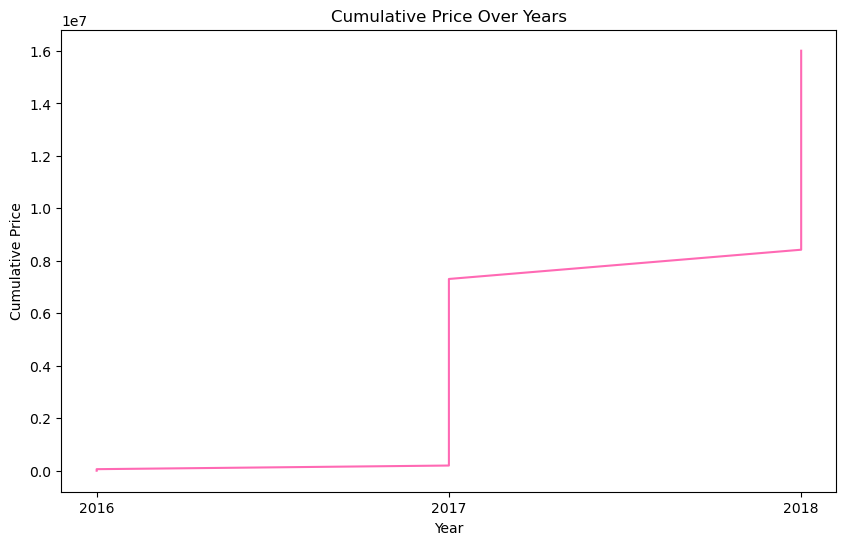

In [37]:
plt.figure(figsize=(10, 6))
plt.plot(df['year'], df['cumulative_price'], linestyle='-', color='hotpink')
plt.title('Cumulative Price Over Years')
plt.xlabel('Year')
plt.ylabel('Cumulative Price')
plt.xticks(df['year'].unique())
plt.show()

# 13.  Calculate the year-over-year growth rate of total sales.

In [44]:
query = """WITH a AS (SELECT YEAR(orders.order_purchase_timestamp) AS years,
ROUND(SUM(payments.payment_value),2) AS payment FROM orders JOIN payments
ON orders.order_id = payments.order_id
GROUP BY years
ORDER BY years)

SELECT years,((payment - LAG(payment, 1) OVER(ORDER BY years))/LAG(payment, 1) OVER(ORDER BY years)) * 100 FROM a;"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years","yoy % growth"])
df

,years,yoy % growth
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924


# 14. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [45]:
query = """WITH a AS (SELECT customers.customer_id,
min(orders.order_purchase_timestamp) first_order
FROM customers JOIN orders
USING(customer_id)
GROUP BY customers.customer_id),

b AS (SELECT a.customer_id, COUNT(DISTINCT orders.order_purchase_timestamp)
FROM a JOIN orders
ON orders.customer_id = a.customer_id
AND orders.order_purchase_timestamp > first_order
AND orders.order_purchase_timestamp < DATE_ADD(first_order, interval 6 month)
GROUP BY a.customer_id)

SELECT 100* (COUNT(DISTINCT a.customer_id)/COUNT(DISTINCT b.customer_id))
FROM a left JOIN b
ON a.customer_id = b.customer_id;"""
cur.execute(query)
data = cur.fetchall()
data

[(None,)]

# 15. Identify the top 3 customers who spent the most money in each year.

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, 'a9dc96b027d1252bbac0a9b72d837fc6'),
  Text(1, 0, '1d34ed25963d5aae4cf3d7f3a4cda173'),
  Text(2, 0, '4a06381959b6670756de02e07b83815f'),
  Text(3, 0, '1617b1357756262bfa56ab541c47bc16'),
  Text(4, 0, 'c6e2731c5b391845f6800c97401a43a9'),
  Text(5, 0, '3fd6777bbce08a352fddd04e4a7cc8f6'),
  Text(6, 0, 'ec5b2ba62e574342386871631fafd3fc'),
  Text(7, 0, 'f48d464a0baaea338cb25f816991ab1f'),
  Text(8, 0, 'e0a2412720e9ea4f26c1ac985f6a7358')])

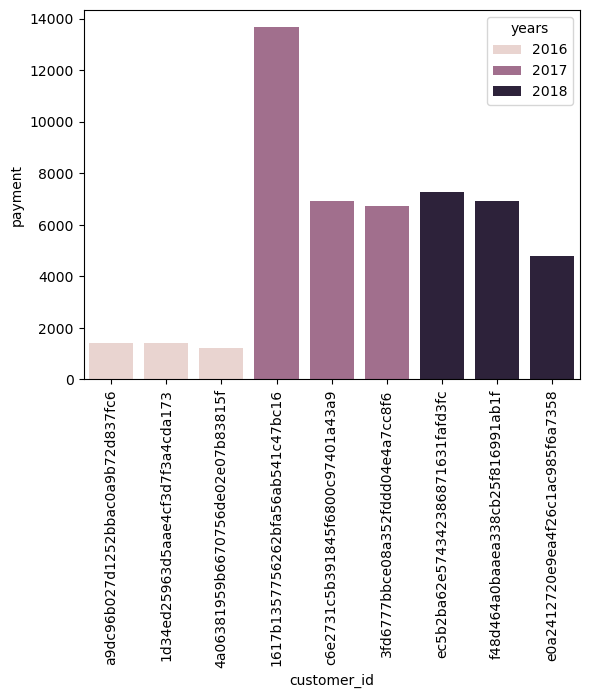

In [51]:
query = """SELECT years, customer_id, payment, d_rank
FROM
(SELECT year(orders.order_purchase_timestamp) years,
orders.customer_id,
SUM(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by SUM(payments.payment_value) desc) d_rank
FROM orders JOIN payments
ON payments.order_id = orders.order_id
GROUP BY year(orders.order_purchase_timestamp), orders.customer_id) AS a
WHERE d_rank <= 3;"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years","customer_id","payment","rank"])
sns.barplot(x="customer_id", y="payment", data = df, hue = "years")
plt.xticks(rotation = 90)